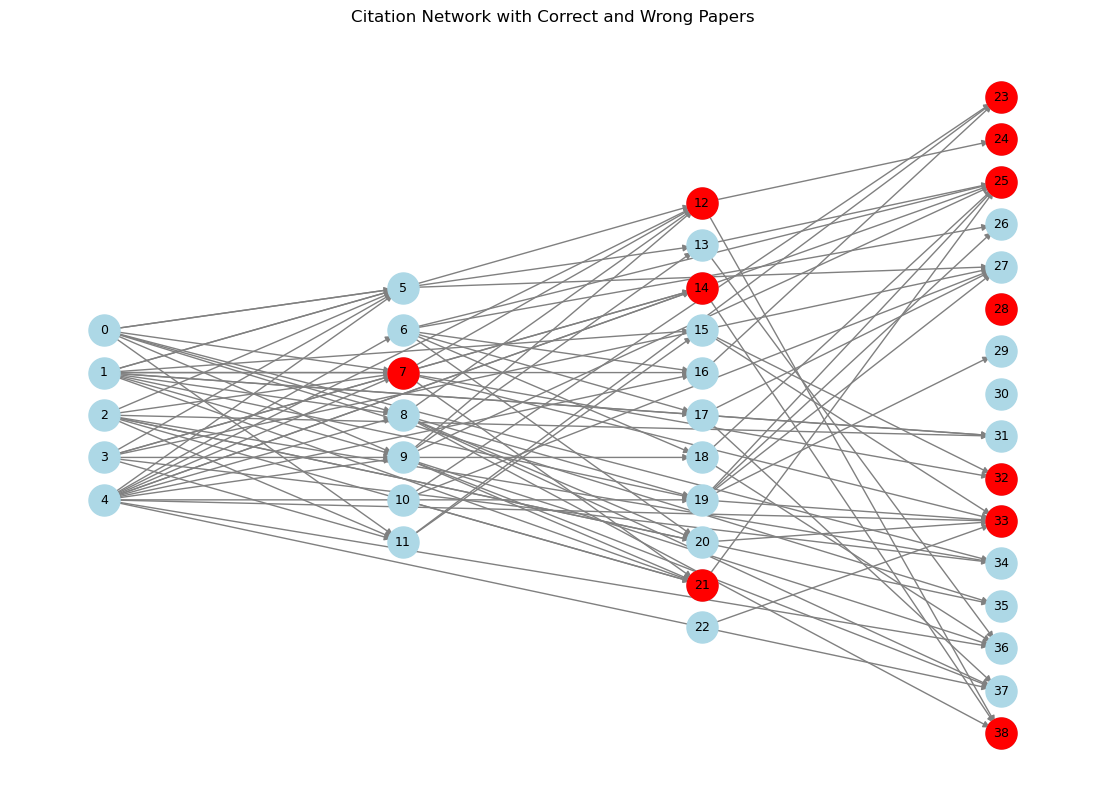

In [36]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def create_growing_citation_network_with_wrong_papers(starting_nodes, generations, average_degree, growth_rate, beta):
    G = nx.DiGraph()
    last_node_id = starting_nodes - 1  # Initialize the last node ID
    node_layers = {i: 0 for i in range(starting_nodes)}  # Initial layer assignment
    
    # Add starting nodes
    G.add_nodes_from(range(starting_nodes))
    
    for generation in range(1, generations + 1):
        nodes_to_add = int(starting_nodes * (growth_rate ** generation))
        for _ in range(nodes_to_add):
            new_node_id = last_node_id + 1
            G.add_node(new_node_id)
            node_layers[new_node_id] = generation
            
            # Determine citations (edges)
            num_edges = np.random.poisson(average_degree)
            possible_targets = [node for node, layer in node_layers.items() if layer < generation]
            num_edges = min(num_edges, len(possible_targets))
            
            if num_edges > 0:
                target_nodes = np.random.choice(possible_targets, size=num_edges, replace=False)
                # Add edges pointing from cited (older) to citing (newer) papers
                G.add_edges_from([(target_node, new_node_id) for target_node in target_nodes])
            
            last_node_id = new_node_id
    
    # Mark wrong papers
    all_nodes = list(G.nodes)
    num_wrong = int(np.ceil(beta * len(all_nodes)))
    wrong_nodes = set(np.random.choice(all_nodes, size=num_wrong, replace=False))
    
    # Propagate wrongness
    wrongness_propagated = set()
    for node in wrong_nodes:
        descendants = nx.descendants(G, node)  # Get all nodes that indirectly cite this wrong paper
        wrongness_propagated.update(descendants)
    wrong_nodes.update(wrongness_propagated)
    
    return G, node_layers, wrong_nodes


def assign_positions(node_layers):
    # Determine the number of layers and their widths
    layer_counts = defaultdict(int)
    for layer in node_layers.values():
        layer_counts[layer] += 1
    
    # Assign positions within each layer
    positions = {}
    for node, layer in node_layers.items():
        # Calculate horizontal position within layer
        # Horizontal position spreads nodes evenly within each layer
        width = layer_counts[layer]
        layer_nodes = [n for n, l in node_layers.items() if l == layer]
        sorted_layer_nodes = sorted(layer_nodes)
        index = sorted_layer_nodes.index(node)
        x = layer
        y = (index - width / 2) * -1  # Negative to invert direction for visual clarity
        
        positions[node] = (x, y)
    
    return positions


def draw_network(G, positions, wrong_nodes):
    plt.figure(figsize=(14, 10))
    # Draw all nodes first, then highlight wrong ones
    nx.draw_networkx_nodes(G, positions, node_size=500, node_color='lightblue')
    nx.draw_networkx_nodes(G, positions, nodelist=list(wrong_nodes), node_size=500, node_color='red')
    nx.draw_networkx_edges(G, positions, edge_color='grey')
    nx.draw_networkx_labels(G, positions, font_size=9)
    plt.title('Citation Network with Correct and Wrong Papers')
    plt.axis('off')
    plt.savefig('citation_network.png')
    plt.show()

# Parameters for the network
starting_nodes = 5
generations = 3
average_degree = 3
growth_rate = 1.5

# Example for a single beta value
beta = 0.1  # Fraction of papers that are initially wrong

# Create the network
G, node_layers, wrong_nodes = create_growing_citation_network_with_wrong_papers(starting_nodes, generations, average_degree, growth_rate, beta)

# Assign positions for visualization
positions = assign_positions(node_layers)

# Visualize the network
draw_network(G, positions, wrong_nodes)


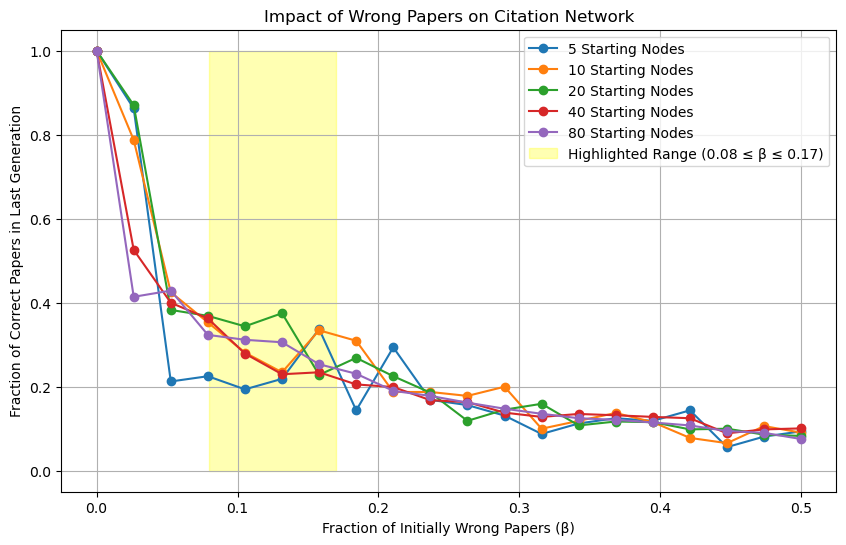

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def simulate_impact_of_wrong_papers(starting_nodes, generations, average_degree, growth_rate, beta_values):
    results = []  # To store the fraction of correct papers for each beta
    
    for beta in beta_values:
        # Generate the network
        G, node_layers, wrong_nodes = create_growing_citation_network_with_wrong_papers(
            starting_nodes, generations, average_degree, growth_rate, beta)
        
        # Calculate the fraction of correct papers in the last generation
        last_generation_nodes = [node for node, layer in node_layers.items() if layer == generations]
        wrong_in_last_gen = wrong_nodes.intersection(last_generation_nodes)
        fraction_correct = 1 - (len(wrong_in_last_gen) / len(last_generation_nodes))
        results.append(fraction_correct)
    
    return results

# Parameters for the simulation
starting_nodes_list = [5, 10, 20, 40, 80]  # Range of starting nodes to test
generations = 5
average_degree = 2
growth_rate = 2
beta_values = np.linspace(0, 0.5, 20)  # Range of beta values to test
fractions_list = []

# Run the simulations
for starting_nodes in starting_nodes_list:
    fractions_correct = simulate_impact_of_wrong_papers(starting_nodes, generations, average_degree, growth_rate, beta_values)
    fractions_list.append(fractions_correct)

# Plot fractions_corret[i] vs beta_values for each starting_nodes[i] in the same figure
plt.figure(figsize=(10, 6))
for i in range(len(starting_nodes_list)):
    plt.plot(beta_values, fractions_list[i], marker='o', linestyle='-', label=f'{starting_nodes_list[i]} Starting Nodes')

plt.title('Impact of Wrong Papers on Citation Network')
plt.xlabel('Fraction of Initially Wrong Papers (β)')
plt.ylabel('Fraction of Correct Papers in Last Generation')
plt.grid(True)

# Highlight the range of interest
highlight_start = 0.08
highlight_end = 0.17
plt.fill_betweenx([0, 1], highlight_start, highlight_end, color='yellow', alpha=0.3, label='Highlighted Range (0.08 ≤ β ≤ 0.17)')

# Adjusting legend to ensure it shows our labels
plt.legend(loc='best')

plt.savefig('impact_of_wrong_papers.png')

plt.show()


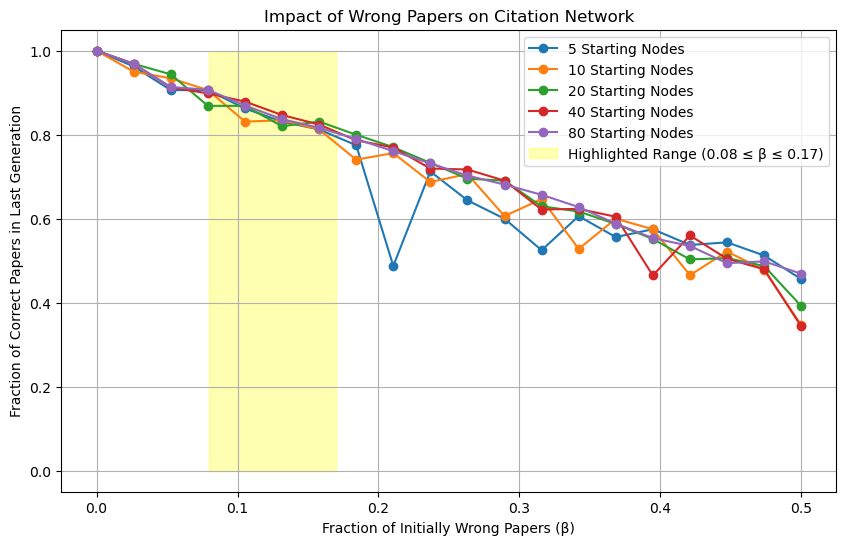

In [35]:
def create_growing_citation_network_with_selective_wrong_papers(starting_nodes, generations, average_degree, growth_rate, beta):
    G = nx.DiGraph()
    last_node_id = starting_nodes - 1
    node_layers = {i: 0 for i in range(starting_nodes)}
    
    # Add starting nodes
    G.add_nodes_from(range(starting_nodes))
    
    for generation in range(1, generations + 1):
        nodes_to_add = int(starting_nodes * (growth_rate ** generation))
        for _ in range(nodes_to_add):
            new_node_id = last_node_id + 1
            G.add_node(new_node_id)
            node_layers[new_node_id] = generation
            
            num_edges = np.random.poisson(average_degree)
            possible_targets = [node for node, layer in node_layers.items() if layer < generation]
            num_edges = min(num_edges, len(possible_targets))
            
            if num_edges > 0:
                target_nodes = np.random.choice(possible_targets, size=num_edges, replace=False)
                G.add_edges_from([(target_node, new_node_id) for target_node in target_nodes])
            
            last_node_id = new_node_id
    
    # Identify nodes with less than average connections
    degrees = dict(G.degree())
    average_degree = np.mean(list(degrees.values()))
    eligible_nodes = [node for node, degree in degrees.items() if degree < average_degree]
    
    # Mark a fraction β of these as wrong
    num_wrong = int(np.ceil(beta * len(eligible_nodes)))
    wrong_nodes = set(np.random.choice(eligible_nodes, size=num_wrong, replace=False))
    
    # Propagate wrongness
    wrongness_propagated = set()
    for node in wrong_nodes:
        descendants = nx.descendants(G, node)
        wrongness_propagated.update(descendants)
    wrong_nodes.update(wrongness_propagated)
    
    return G, node_layers, wrong_nodes


def simulate_impact_of_wrong_papers_V2(starting_nodes, generations, average_degree, growth_rate, beta_values):
    results = []  # To store the fraction of correct papers for each beta
    
    for beta in beta_values:
        # Generate the network
        G, node_layers, wrong_nodes = create_growing_citation_network_with_selective_wrong_papers(
            starting_nodes, generations, average_degree, growth_rate, beta)
        
        # Calculate the fraction of correct papers in the last generation
        last_generation_nodes = [node for node, layer in node_layers.items() if layer == generations]
        wrong_in_last_gen = wrong_nodes.intersection(last_generation_nodes)
        fraction_correct = 1 - (len(wrong_in_last_gen) / len(last_generation_nodes))
        results.append(fraction_correct)
    
    return results

# Parameters for the simulation
starting_nodes_list = [5, 10, 20, 40, 80]  # Range of starting nodes to test
generations = 5
average_degree = 2
growth_rate = 2
beta_values = np.linspace(0, 0.5, 20)  # Range of beta values to test
fractions_list = []

# Run the simulations
for starting_nodes in starting_nodes_list:
    fractions_correct = simulate_impact_of_wrong_papers_V2(starting_nodes, generations, average_degree, growth_rate, beta_values)
    fractions_list.append(fractions_correct)

# Plot fractions_corret[i] vs beta_values for each starting_nodes[i] in the same figure
plt.figure(figsize=(10, 6))
for i in range(len(starting_nodes_list)):
    plt.plot(beta_values, fractions_list[i], marker='o', linestyle='-', label=f'{starting_nodes_list[i]} Starting Nodes')

plt.title('Impact of Wrong Papers on Citation Network')
plt.xlabel('Fraction of Initially Wrong Papers (β)')
plt.ylabel('Fraction of Correct Papers in Last Generation')
plt.grid(True)

# Highlight the range of interest
highlight_start = 0.08
highlight_end = 0.17
plt.fill_betweenx([0, 1], highlight_start, highlight_end, color='yellow', alpha=0.3, label='Highlighted Range (0.08 ≤ β ≤ 0.17)')

# Adjusting legend to ensure it shows our labels
plt.legend(loc='best')

plt.savefig('impact_of_wrong_papers_V2.png')

plt.show()
